# Versione 2.0

In [1]:
import os
import pickle
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:

#modello VGG16
model = VGG16()

model = Model(inputs = model.inputs, outputs = model.layers[-2].output)  
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:

#creazione di un dizionario vuoto che verrà usato per memorizzare le features estratte
features = {}
# immagini
immagini = os.listdir('Flickr8K/Flicker8k_Images/')
# loop sulle immagini
for nome_img in immagini:
    # Si costruisce il percorso completo dell'immagine utilizzando il nome del file e la directory
    img_path = 'Flickr8K/Flicker8k_Images/' + nome_img
    #Si carica l'immagine
    immagine = load_img(img_path, target_size=(224, 224))
    # L'immagine viene convertita in un array (l'immagine originariamente è una matrice di pixel)
    immagine = img_to_array(immagine)
    #  viene aggiunto un nuovo asse iniziale per formare una forma (1, altezza, larghezza, canali) 
    #  al fine di creare un singolo campione.
    immagine = immagine.reshape((1, immagine.shape[0], immagine.shape[1], immagine.shape[2]))
    # Proprocessing dell'immagine per il modello VGG
    immagine = preprocess_input(immagine)
    # Estrazione delle features dall'immagine pre-processata
    feature = model.predict(immagine, verbose=0)
    
    # ID dell'immagine -> si ottiene l'ID dell'immagine estraendo il nome del file senza l'estensione
    img_id = nome_img.split('.')[0]
    # Memorizzazione delle features
    features[img_id] = feature
    #il dizionario "features" conterrà le features estratte da tutte le immagini presenti nella directory

# tempo impiegato: 131m24s

In [5]:
# Dato il tempo riportato sopra, è stato uyili memorizzare le features    
# Memorizzazione delle features in pickle
#pickle.dump(features, open('C:/Users/ricca/OneDrive/Desktop/UNI_Magistrale/Corsi/2 anno/2 semestre/DeepLearning/Lab/ProgettoDeepLearning/ImageCaption/features2Model.pkl', 'wb'))
features = {}
immagini = os.listdir('Flickr8K/Flicker8k_Images/')
# Caricamento delle features da pickle
with open('C:/Users/ricca/OneDrive/Desktop/UNI_Magistrale/Corsi/2 anno/2 semestre/DeepLearning/Lab/ProgettoDeepLearning/ImageCaption/features2Model.pkl', 'rb') as f:
   features = pickle.load(f) 
   

# *************** CARICAMENTO DELLE CAPTION DELLE IMMAGINI *************** 
with open('Flickr8K/Flickr8k_text/Flickr8k.token.txt', 'r') as f:
    captions_doc = f.read()
    

In [6]:
mapping = {}
for line in captions_doc.split('\n'):   # si lavora su una riga alla volta
    # Split della linea con #
    tokens = line.split('#')
    if len(line) < 2:
        continue
    id_immagine = tokens[0].split('.')[0]   # viene tolta l'estensione
    if (id_immagine + '.jpg') not in immagini:  # inserisco solo le caption di cui c'è l'immagine
        continue
    caption = " ".join(tokens[1:])      # converto da lista a stringa
    caption = " ".join((caption.split('\t'))[1:]) 
    
    # Inizializza la lista se non è ancora presente
    if id_immagine not in mapping:
        mapping[id_immagine] = []
    mapping[id_immagine].append(caption)
    
len(mapping)

8091

In [7]:
# *************** PREPROCESSAMENTO DELLE CAPTION (E CREAZIONE DEL TOKENIZZATORE) ***************  
for id_immagine, captions in mapping.items():
    for i in range(len(captions)):
        # lavoro su una caption per volta
        caption = captions[i]
        # Si converte tutto in minuscolo
        caption = caption.lower()
        # Si eliminano caratteri speciali
        caption = caption.replace('[^A-Za-z]', '')
        # Si eliminano spazi inutili
        caption = caption.replace('\s+', ' ')
        # Si aggiunge il tag di inizio e fine caption (e si considerano solo le parole composte da minimo due lettere)
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
        captions[i] = caption


all_captions = []
for id_immagine in mapping:
    for caption in mapping[id_immagine]:
        all_captions.append(caption)
        

# Tokenizzazione del testo
# Tokenizer -> utilizzata per convertire il testo in sequenze di token (parole o sottostringhe significative)
tokenizer = Tokenizer()
# il tokenizer viene "addestrato" sui testi delle didascalie delle immagini
#il tokenizer analizzerà le didascalie per costruire il proprio vocabolario interno e assegnare un numero intero 
# univoco a ciascuna parola presente nelle didascalie
tokenizer.fit_on_texts(all_captions)
# determino la dimensione del vocabolario totale
dimensione_vocabolario = len(tokenizer.word_index) + 1  # word_index è il numero di parole univoche che ci sono

# Massima lunghezza della caption disponibile (per il padding successivo) 
max_lunghezza_caption = max(len(caption.split()) for caption in all_captions)

In [8]:
#  Training e test set (già splittati in dei file)
with open('Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt', 'r') as f:
    training_set_doc = f.read()

training_set = []
for line in training_set_doc.split('\n'):   # tolgo l'estensione ad ogni riga
    id_immagine = line.split('.')[0]   
    if id_immagine not in mapping:
        continue
    training_set.append(id_immagine)
    
    
with open('Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt', 'r') as f:
    test_set_doc = f.read()

test_set = []
for line in test_set_doc.split('\n'):   # tolgo l'estensione ad ogni riga
    id_immagine = line.split('.')[0]   
    if id_immagine not in mapping:
        continue
    test_set.append(id_immagine)

In [9]:
# Creazione di un data generator per dividere i dati in batch 
# Un generatore di dati è un modo efficiente per affrontare problemi di memoria, 
# poiché carica ed elabora solo un batch di dati alla volta invece di caricarli tutti in memoria contemporaneamente.
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # input: 
    # data_keys: Lista di chiavi che rappresentano le immagini da utilizzare.
    # mapping: Dizionario che mappa le chiavi alle rispettive didascalie.
    # features: Dizionario che mappa le chiavi alle rispettive rappresentazioni delle immagini.
    # tokenizer: Oggetto tokenizer utilizzato per convertire le didascalie in sequenze di numeri.
    # max_length: Lunghezza massima delle sequenze di testo (didascalie) dopo la tokenizzazione.
    # vocab_size: Dimensione del vocabolario.
    # batch_size: Dimensione del batch da generare in ogni iterazione.
    X1, X2, y = list(), list(), list()
    n = 0        # tiene conto del numero di id analizzati
    while 1:    # viene effettuato un ciclo per tutte le immagini
        #Per ogni chaive
        for key in data_keys:
            n += 1
            # Estraggo le caption
            captions = mapping[key]
            # Vper ogni caption dell'immagine
            for caption in captions:
                # Codifica della sequenza
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # split nella coppia input e output
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence (si deve avere una dimensione comune)
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0] #restituisce una lista (perchè possiamo passare più elementi), ma a noi interessa solo il primo
                    # encode output sequence (converte in one-hot encoding)
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    # Memorizzazione delle sequenze
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y     # produce una sequenza di valori
                X1, X2, y = list(), list(), list()
                n = 0

All'interno del ciclo for key in data_keys, nella funzione data_generator, vengono considerate tutte le immagini una dopo l'altra. Per ciascuna immagine, il generatore crea una serie di coppie di input-output basate sulle didascalie associate a quella specifica immagine.

ES:  "startseq girl going into wooden building endseq"

Ciclo di Creazione delle Coppie:

    La didascalia viene divisa in token individuali: ["startseq", "girl", "going", "into", "wooden", "building", "endseq"].

    Si inizia con il primo token ("startseq") e si crea una coppia di input-output:

    Input: ["startseq"]
    Output: "girl"
    Si passa al secondo token ("girl") e si crea una nuova coppia di input-output:

    Input: ["startseq", "girl"]
    Output: "going"
    Questo processo continua per tutti i token nella sequenza.

Per ogni coppia di input-output:

    L'input (la sequenza di token) viene trasformato in una sequenza di numeri interi utilizzando il tokenizer. Ad esempio, ["startseq", "girl"] potrebbe diventare [1, 5] se "startseq" è mappato all'indice 1 e "girl" all'indice 5.

    La sequenza di numeri interi viene quindi riempita con zeri o tagliata in modo che abbia la lunghezza massima prevista (max_length). Questo assicura che tutte le sequenze abbiano la stessa lunghezza, che è necessario per l'input in un modello di machine learning.

    L'output (il token successivo) viene convertito in one-hot encoding secondo il vocabolario che si è utilizzato

Man mano che le coppie di input-output vengono create e processate, le rappresentazioni delle immagini (X1), le sequenze di testo codificate (X2) e gli output in one-hot encoding (y) vengono memorizzati nelle rispettive liste.

Quando il numero di coppie raggiunge il batch_size specificato, le liste vengono convertite in array NumPy per l'efficienza e il generatore restituisce il batch corrente utilizzando l'istruzione yield.

Dopo aver generato un batch, le liste vengono reimpostate per prepararsi alla generazione del prossimo batch.

# Modello

In [ ]:
'''def build_image_captioning_model(vocab_size, max_caption_length, embedding_dim, hidden_units):
    # Encoder
    image_input = Input(shape=(image_feature_size,))
    encoder = Dense(embedding_dim, activation='relu')(image_input)

    # Decoder
    caption_input = Input(shape=(max_caption_length,))
    caption_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(caption_input)
    decoder_lstm = LSTM(hidden_units, return_sequences=True)(caption_embedding)
    caption_output = Dense(vocab_size, activation='softmax')(decoder_lstm)

    # Modello finale
    model = Model(inputs=[image_input, caption_input], outputs=caption_output)
    return model'''

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  1048832   ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 34, 256)              2172160   ['input_3[0][0]']             
                                                                                            

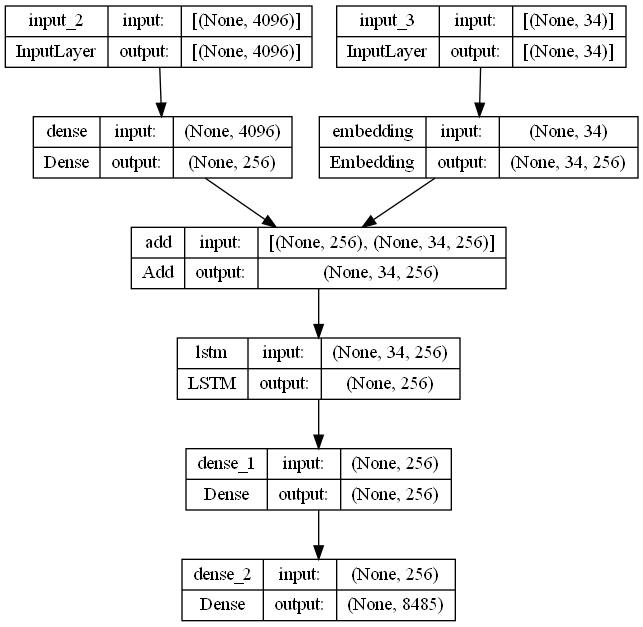

In [10]:
# *************** MODELLO *************** 
inputs1 = Input(shape = (4096,))  # dipende dall'output del VGG
fe1 = Dense(256, activation = 'relu')(inputs1)

inputs2 = Input(shape = (max_lunghezza_caption,))
se1 = Embedding(dimensione_vocabolario, 256, mask_zero = True)(inputs2)  # abbiamo il padding

decoder1 = add([fe1, se1])
lstm  = LSTM(256)(decoder1)
decoder2 = Dense(256, activation = 'relu')(lstm)
outputs = Dense(dimensione_vocabolario, activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

print(model.summary())

# Plot del modello
plot_model(model, show_shapes = True)

In [24]:
# Train the model
from keras.callbacks import EarlyStopping
epochs = 10
batch_size = 32
steps = len(training_set) // batch_size

early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=1, mode='auto')

for i in range(epochs):
    # Creazione del data generator
    generator = data_generator(training_set, mapping, features, tokenizer, max_lunghezza_caption, dimensione_vocabolario, batch_size)
    # Fit del modello per ogni epoca
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[early_stopping])


187/187 [==============================] - 533s 3s/step - loss: 2.6960


In [25]:
# Caption generation
# Prende un indice (integer) e un tokenizer come input e restituisce la parola associata a quell'indice nel vocabolario del tokenizer. 
# Utile per convertire l'output previsto dal modello (l'indice) in una parola leggibile.
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:  
            return word
    return None


# Questa funzione prende il modello addestrato, un'immagine, un tokenizer e la massima lunghezza prevista per la didascalia 
# come input e restituisce la didascalia generata per l'immagine
def predict_caption(model, image, tokenizer, max_length):
    # Inizia con la stringa "startseq" come prima parola nell'input della sequenza della didascalia.
    in_text = 'startseq'
    # Itero attraverso i passi seguenti fino a quando viene generata la didascalia completa o viene incontrato il 
    # termine "endseq" o si raggiunge la massima lunghezza prevista
    for i in range(max_length):
        # La sequenza di parole (dall'inizio fino alla parola attuale) viene convertita in una sequenza di indici utilizzando il tokenizer
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # La sequenza di indici viene riempita per avere la stessa lunghezza massima prevista per la didascalia
        sequence = pad_sequences([sequence], max_length)
        # Il modello viene utilizzato per prevedere la parola successiva nella sequenza
        yhat = model.predict([image, sequence], verbose=0) #non si vuole spiegare niente
        # L'indice della parola prevista con la probabilità più alta viene estratto.
        yhat = np.argmax(yhat)
        # L'indice viene quindi convertito nella parola corrispondente
        word = idx_to_word(yhat, tokenizer)
        # Se la parola non è stata trovata si termina
        if word is None:
            break
        # La parola prevista viene aggiunta all'input della sequenza per generare la parola successiva.
        in_text += " " + word
        # Se la parola prevista è "endseq", la generazione termina, indicando che la didascalia è stata completata
        if word == 'endseq':
            break
    # viene restituita la didascalia generata
    return in_text

In [26]:
# *************** VISUALIZZAZIONE DEI RISULTATI ***************
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = 'Flickr8K/Flicker8k_Images/' + image_name
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Attuale---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_lunghezza_caption)
    print('--------------------Predetta--------------------')
    print(y_pred)
    plt.imshow(image)


---------------------Attuale---------------------
startseq black and white dog is playing with ball on lawn endseq
startseq black and white dog jumps up as ball is thrown over his head endseq
startseq dog jumping looking up and small white ball in air passed by endseq
startseq the black and white dog is attempting to catch ball in the garden endseq
startseq the dog jumps up waiting to catch something being thrown endseq


--------------------Predetta--------------------
startseq black and white dog jumps over an obstacle to catch ball endseq


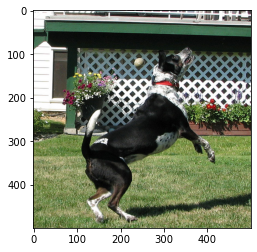

In [33]:
generate_caption("214543992_ce6c0d9f9b.jpg")

---------------------Attuale---------------------
startseq man is riding on red motorcycle endseq
startseq motorcycle driver dressed in orange gear swerves to the right endseq
startseq motorcyclist on red speed bike leans into sharp turn endseq
startseq motorcyclist crouches low as he rounds turn endseq
startseq this person is on red motorcycle endseq
--------------------Predetta--------------------
startseq man in red helmet is riding on his motorcycle endseq


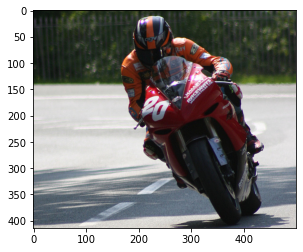

In [28]:
generate_caption("166321294_4a5e68535f.jpg")

---------------------Attuale---------------------
startseq black dog is jumping over white fence whilst taking part in dog show endseq
startseq dog leaps over the hurdle endseq
startseq small dog leaps over striped hurdle endseq
startseq white black and brown dog jumping over hurdle endseq
startseq the dog is leaping over the bar endseq
--------------------Predetta--------------------
startseq dog jumps over hurdle endseq


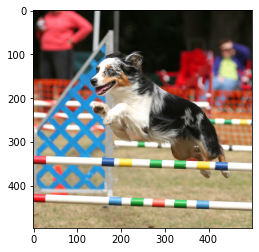

In [29]:
generate_caption("431282339_0aa60dd78e.jpg")

---------------------Attuale---------------------
startseq group of young soccer players run down the field after the ball endseq
startseq boys are playing soccer endseq
startseq the soccer player in the checked shirt is moving the ball pursued by the players on the other team endseq
startseq two boys soccer teams play one boy goes after the ball endseq
startseq two teams of boys playing soccer endseq
--------------------Predetta--------------------
startseq two men in red uniforms are playing football endseq


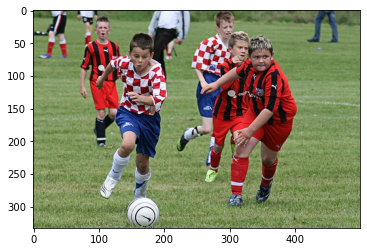

In [30]:

generate_caption("560278886_df4bd2e212.jpg")

---------------------Attuale---------------------
startseq basketball player in the air about to make shot endseq
startseq basketball player jumps up with the ball as two others watch endseq
startseq school basketball game is in progress endseq
startseq basketball player from eastern goes between two defenders for shot endseq
startseq men playing basketball game endseq
--------------------Predetta--------------------
startseq basketball player in white uniform is trying to make shot endseq


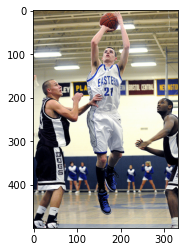

In [34]:
generate_caption("3182558164_488b819f14.jpg")